# Analisi e Previsione della Produzione di Olio d'Oliva

Questo notebook esplora la relazione tra i dati meteorologici e la produzione annuale di olio d'oliva, con l'obiettivo di creare un modello predittivo.

In [1]:
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install keras
!pip install scikit-learn
!pip install matplotlib
!pip install joblib
!pip install pyarrow
!pip install fastparquet
!pip install scipy
!pip install seaborn
!pip install pysolar

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, LayerNormalization, Add, GlobalAveragePooling1D, Activation, BatchNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
import os
import json
import joblib
import re
import pyarrow as pa
import pyarrow.parquet as pq


random_state_value = 42

## 1. Caricamento e preparazione dei Dati Meteo

In [3]:
# Function to convert csv to parquet
def csv_to_parquet(csv_file, parquet_file, chunksize=100000):
    writer = None

    for chunk in pd.read_csv(csv_file, chunksize=chunksize):
        if writer is None:

            table = pa.Table.from_pandas(chunk)
            writer = pq.ParquetWriter(parquet_file, table.schema)
        else:
            table = pa.Table.from_pandas(chunk)

        writer.write_table(table)

    if writer:
        writer.close()

    print(f"File conversion completed : {csv_file} -> {parquet_file}")


def read_json_files(folder_path):
    all_data = []

    file_list = sorted(os.listdir(folder_path))

    for filename in file_list:
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    all_data.extend(data['days'])
            except Exception as e:
                print(f"Error processing file '{filename}': {str(e)}")

    return all_data


def create_weather_dataset(data):
    dataset = []
    seen_datetimes = set()

    for day in data:
        date = day['datetime']
        for hour in day['hours']:
            datetime_str = f"{date} {hour['datetime']}"

            # Verifico se questo datetime è già stato visto
            if datetime_str in seen_datetimes:
                continue

            seen_datetimes.add(datetime_str)

            if isinstance(hour['preciptype'], list):
                preciptype = "__".join(hour['preciptype'])
            else:
                preciptype = hour['preciptype'] if hour['preciptype'] else ""

            conditions = hour['conditions'].replace(', ', '__').replace(' ', '_').lower()

            row = {
                'datetime': datetime_str,
                'temp': hour['temp'],
                'feelslike': hour['feelslike'],
                'humidity': hour['humidity'],
                'dew': hour['dew'],
                'precip': hour['precip'],
                'snow': hour['snow'],
                'preciptype': preciptype.lower(),
                'windspeed': hour['windspeed'],
                'winddir': hour['winddir'],
                'pressure': hour['pressure'],
                'cloudcover': hour['cloudcover'],
                'visibility': hour['visibility'],
                'solarradiation': hour['solarradiation'],
                'solarenergy': hour['solarenergy'],
                'uvindex': hour['uvindex'],
                'conditions': conditions,
                'tempmax': day['tempmax'],
                'tempmin': day['tempmin'],
                'precipprob': day['precipprob'],
                'precipcover': day['precipcover']
            }
            dataset.append(row)

    dataset.sort(key=lambda x: datetime.strptime(x['datetime'], "%Y-%m-%d %H:%M:%S"))

    return pd.DataFrame(dataset)


folder_path = './data/weather'
raw_data = read_json_files(folder_path)
weather_data = create_weather_dataset(raw_data)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], errors='coerce')
weather_data['date'] = weather_data['datetime'].dt.date
weather_data = weather_data.dropna(subset=['datetime'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
weather_data['year'] = weather_data['datetime'].dt.year
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['day'] = weather_data['datetime'].dt.day
weather_data.head()

weather_data.to_parquet('./data/weather_data.parquet')

File conversion completed : ./data/weather_data.csv -> ./data/weather_data.parquet


In [4]:
# Funzione per creare sequenze per LSTM
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

# Funzioni per costruire il modello LSTM avanzato
def create_residual_lstm_layer(x, units, dropout_rate, l2_reg=0.01):
    residual = x
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # Adjust residual dimension
    if int(residual.shape[-1]) != 2 * units:
        residual = Dense(2 * units, activation='linear')(residual)
    x = Add()([x, residual])
    return x

def attention_block(x, units, num_heads=8):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=units)(x, x)
    x = Add()([x, attention])
    x = LayerNormalization()(x)
    return x

def build_advanced_model(input_shape, l2_lambda=0.005):
    inputs = Input(shape=input_shape)
    x = create_residual_lstm_layer(inputs, 64, 0.3, l2_lambda)
    x = create_residual_lstm_layer(x, 32, 0.3, l2_lambda)
    x = create_residual_lstm_layer(x, 16, 0.2, l2_lambda)
    x = attention_block(x, 16, num_heads=8)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, kernel_regularizer=l2(l2_lambda))(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def get_season(date):
    month = date.month
    day = date.day
    if (month == 12 and day >= 21) or (month <= 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month <= 12 and day < 21):
        return 'Autumn'
    else:
        return 'Unknown'

def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

def add_time_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['timestamp'] = df['datetime'].astype(np.int64) // 10 ** 9
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['datetime'].dt.quarter
    df['is_month_end'] = df['datetime'].dt.is_month_end.astype(int)
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = df['datetime'].dt.is_year_end.astype(int)
    df['month_sin'] = np.sin(df['month'] * (2 * np.pi / 12))
    df['month_cos'] = np.cos(df['month'] * (2 * np.pi / 12))
    df['day_of_year_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25))
    df['day_of_year_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365.25))
    df['season'] = df['datetime'].apply(get_season)
    df['time_period'] = df['hour'].apply(get_time_period)
    return df

# Carica il dataset
weather_data = pd.read_parquet('./data/weather_data.parquet')

# Aggiungi le caratteristiche temporali
weather_data = add_time_features(weather_data)

# Encoding delle variabili categoriali
weather_data = pd.get_dummies(weather_data, columns=['season', 'time_period'], drop_first=True)

weather_data.to_parquet('./data/weather_data_extended.parquet')

# Dividi i dati in quelli dopo il 2010 e quelli prima del 2010
data_after_2010 = weather_data[weather_data['year'] >= 2010].copy()
data_before_2010 = weather_data[weather_data['year'] < 2010].copy()

# Aggiorna le target variables se necessario
target_variables = ['solarradiation', 'solarenergy', 'uvindex']

# Seleziona le features
features = [
               'temp', 'tempmin', 'tempmax', 'humidity', 'cloudcover', 'windspeed', 'pressure', 'visibility',
               'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos',
           ] + [col for col in weather_data.columns if 'season_' in col or 'time_period_' in col]

# Prepara data_after_2010
data_after_2010 = data_after_2010.sort_values('datetime')
data_after_2010.set_index('datetime', inplace=True)

# Interpola eventuali valori mancanti nelle variabili target
columns_to_interpolate = target_variables
for column in columns_to_interpolate:
    data_after_2010[column] = data_after_2010[column].interpolate(method='time')

# Rimuovi eventuali valori mancanti residui
data_after_2010.dropna(subset=features + target_variables, inplace=True)

# Crea X e y
X = data_after_2010[features].values
y = data_after_2010[target_variables].values

# Normalizza le features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalizza le target variables
scalers_y = {}
y_scaled = np.zeros_like(y)

for i, target in enumerate(target_variables):
    scaler = MinMaxScaler()
    y_scaled[:, i] = scaler.fit_transform(y[:, i].reshape(-1, 1)).flatten()
    scalers_y[target] = scaler

# Suddividi i dati in training e test
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Suddividi ulteriormente in training e validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

# Definisci il numero di timesteps (ad esempio, utilizziamo le ultime 24 ore)
timesteps = 24
num_features = X_train.shape[1]

# Crea le sequenze per LSTM
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

# Costruisci il modello per ogni variabile target
models = {}
histories = {}
for i, target in enumerate(target_variables):
    print(f"Addestramento del modello per: {target}")
    model = build_advanced_model((timesteps, num_features), l2_lambda=0.001)
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq[:, i],
        validation_data=(X_val_seq, y_val_seq[:, i]),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )
    test_loss = model.evaluate(X_test_seq, y_test_seq[:, i])
    print(f'Test MAE per {target}: {test_loss:.4f}')
    models[target] = model
    histories[target] = history

# Previsione delle variabili mancanti per data_before_2010
# Prepara data_before_2010
data_before_2010 = data_before_2010.sort_values('datetime')
data_before_2010.set_index('datetime', inplace=True)

# Assicurati che le features non abbiano valori mancanti
data_before_2010[features] = data_before_2010[features].ffill()
data_before_2010[features] = data_before_2010[features].bfill()

# Crea X per data_before_2010
X_before = data_before_2010[features].values
X_before_scaled = scaler_X.transform(X_before)

# Crea le sequenze per LSTM
X_before_seq = []
for i in range(len(X_before_scaled) - timesteps):
    X_before_seq.append(X_before_scaled[i:i+timesteps])
X_before_seq = np.array(X_before_seq)

# Prevedi le variabili mancanti
for i, target in enumerate(target_variables):
    print(f"Previsione di {target} per data_before_2010")
    y_pred_scaled = models[target].predict(X_before_seq)
    # Ricostruisci i valori originali
    scaler = scalers_y[target]
    y_pred = scaler.inverse_transform(y_pred_scaled)

    # Allinea le previsioni con le date corrette
    dates = data_before_2010.index[timesteps:]
    data_before_2010.loc[dates, target] = y_pred

# Gestisci eventuali valori iniziali mancanti
data_before_2010[target_variables] = data_before_2010[target_variables].bfill()

# Combina data_before_2010 e data_after_2010
weather_data_complete = pd.concat([data_before_2010, data_after_2010], axis=0)
weather_data_complete = weather_data_complete.sort_index()

# Salva il dataset completo
weather_data_complete.reset_index(inplace=True)
weather_data_complete.to_parquet('./data/weather_data_complete.parquet', index=False)


Addestramento del modello per: solarradiation


2024-10-22 22:25:57.972773: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-22 22:25:57.972869: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-22 22:25:57.972885: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-22 22:25:57.973640: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-22 22:25:57.974352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-10-22 22:26:02.745785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 454/1297 ━━━━━━━━━━━━━━━━━━━━ 8:52 631ms/step - loss: 0.5095

KeyboardInterrupt: 

## 2. Esplorazione dei Dati Meteo

In [15]:
weather_data = pd.read_parquet('./data/weather_data_complete.parquet')

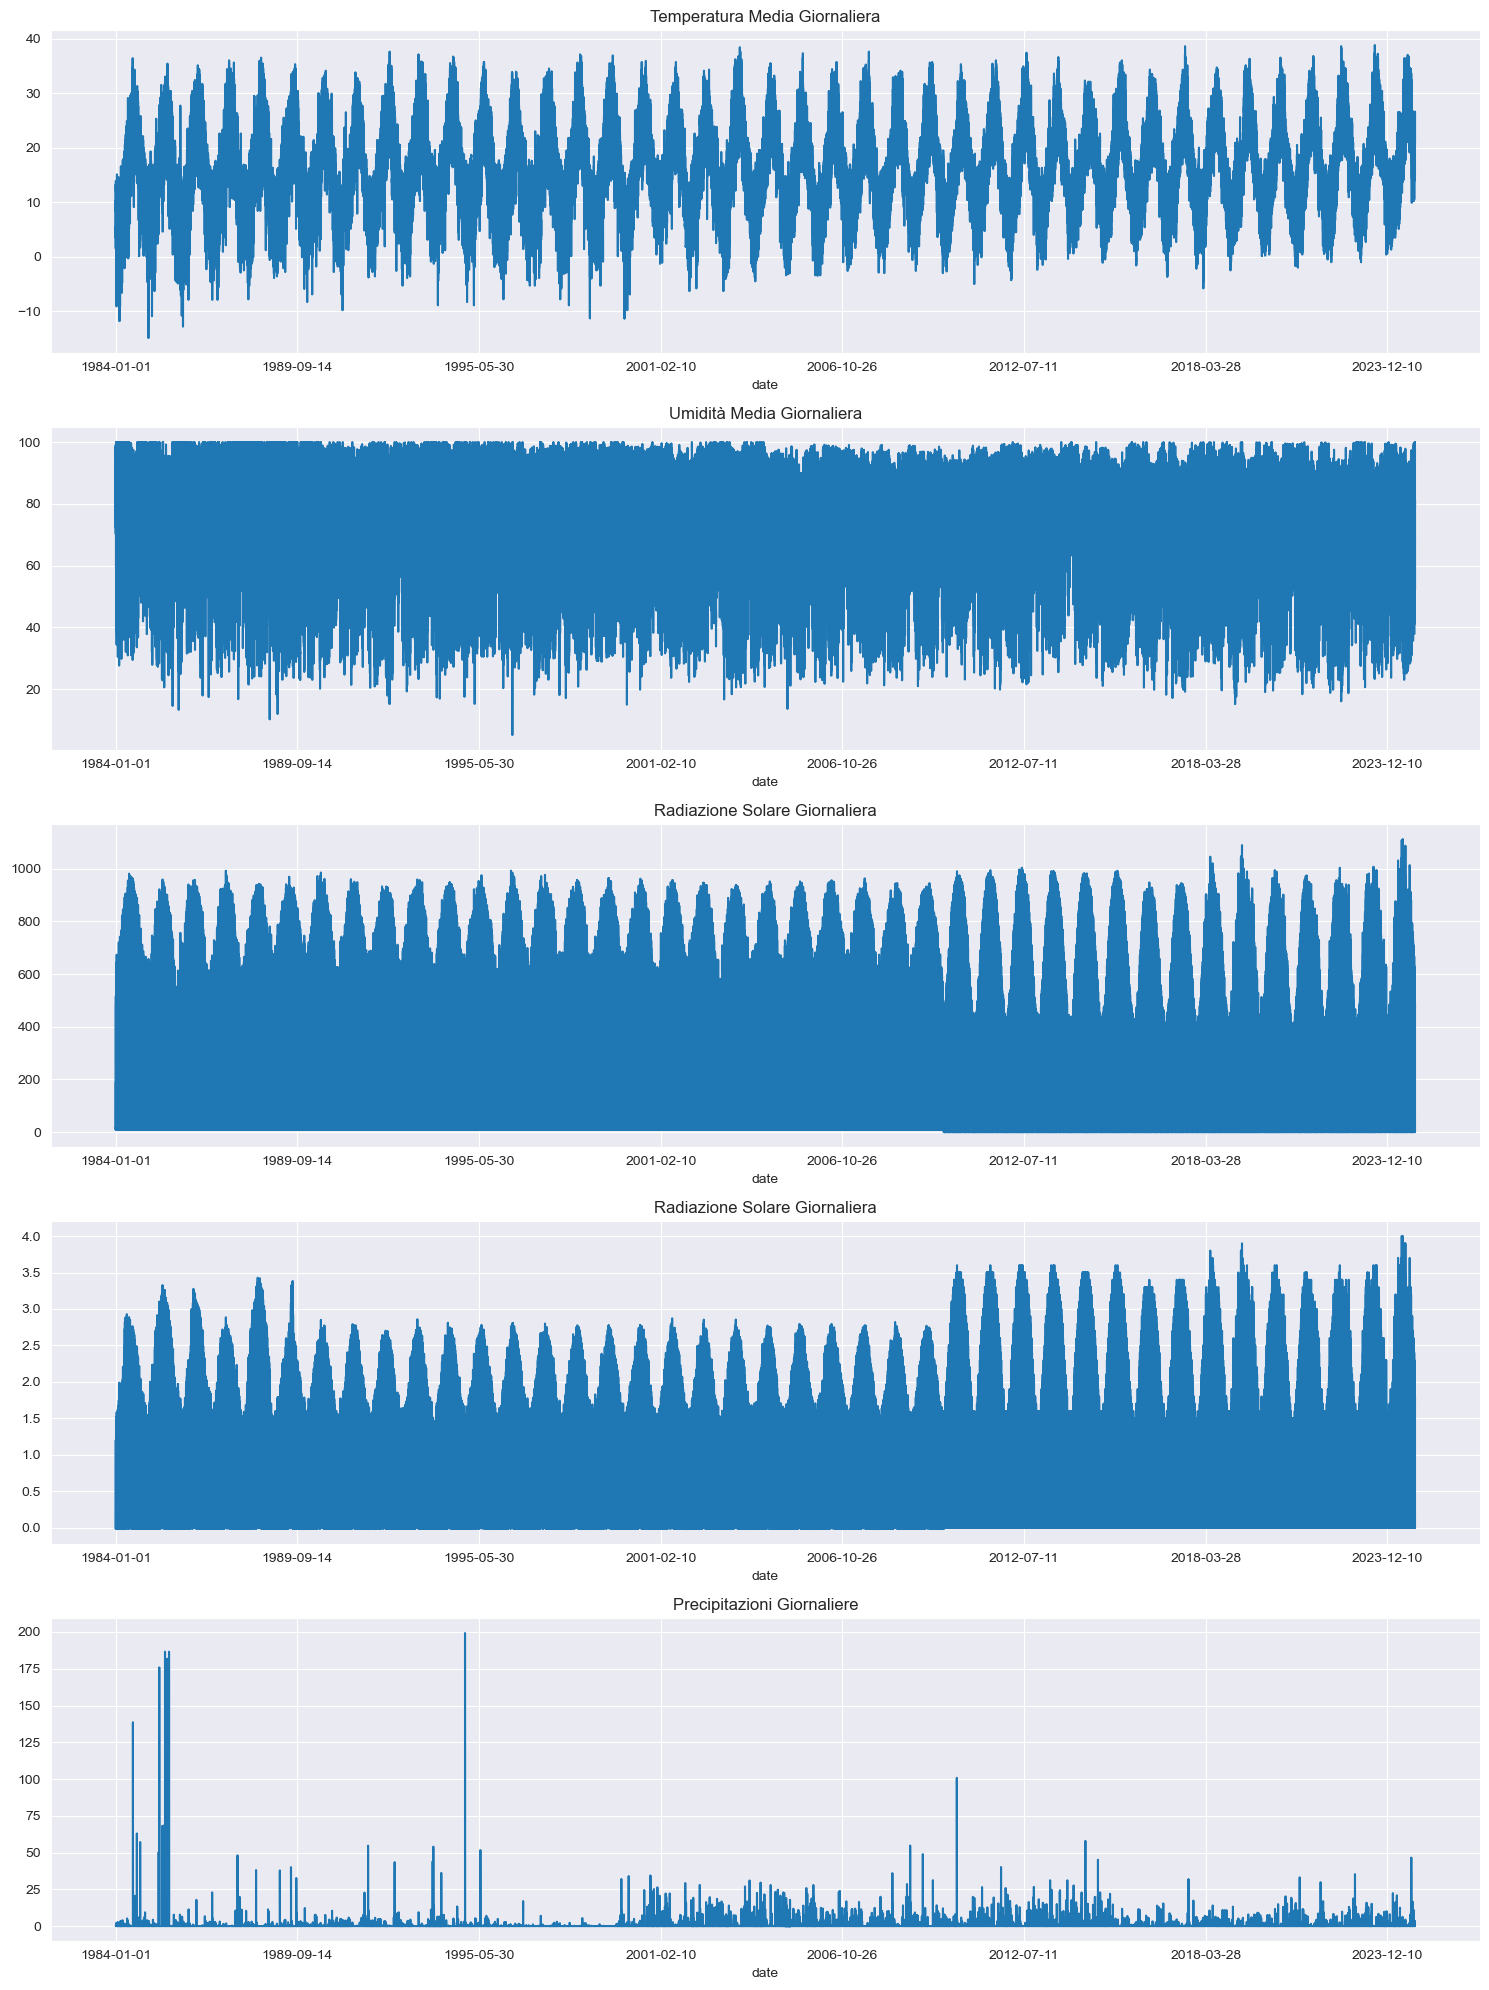

In [16]:
# Visualizzazione delle tendenze temporali
fig, axes = plt.subplots(5, 1, figsize=(15, 20))
weather_data.set_index('date')['temp'].plot(ax=axes[0], title='Temperatura Media Giornaliera')
weather_data.set_index('date')['humidity'].plot(ax=axes[1], title='Umidità Media Giornaliera')
weather_data.set_index('date')['solarradiation'].plot(ax=axes[2], title='Radiazione Solare Giornaliera')
weather_data.set_index('date')['solarenergy'].plot(ax=axes[3], title='Radiazione Solare Giornaliera')
weather_data.set_index('date')['precip'].plot(ax=axes[4], title='Precipitazioni Giornaliere')
plt.tight_layout()
plt.show()

## 3. Simulazione dei Dati di Produzione Annuale

In [9]:

# Esempio di utilizzo
olive_varieties = pd.read_csv('./data/variety_olive_oil_production.csv')


def add_olive_water_consumption_correlation(dataset):
    # Dati simulati per il fabbisogno d'acqua e la correlazione con la temperatura
    fabbisogno_acqua = {
        "Nocellara dell'Etna": {"Primavera": 1200, "Estate": 2000, "Autunno": 1000, "Inverno": 500, "Temperatura Ottimale": 18, "Resistenza": "Media"},
        "Leccino": {"Primavera": 1000, "Estate": 1800, "Autunno": 800, "Inverno": 400, "Temperatura Ottimale": 20, "Resistenza": "Alta"},
        "Frantoio": {"Primavera": 1100, "Estate": 1900, "Autunno": 900, "Inverno": 450, "Temperatura Ottimale": 19, "Resistenza": "Alta"},
        "Coratina": {"Primavera": 1300, "Estate": 2200, "Autunno": 1100, "Inverno": 550, "Temperatura Ottimale": 17, "Resistenza": "Media"},
        "Moraiolo": {"Primavera": 1150, "Estate": 2100, "Autunno": 900, "Inverno": 480, "Temperatura Ottimale": 18, "Resistenza": "Media"},
        "Pendolino": {"Primavera": 1050, "Estate": 1850, "Autunno": 850, "Inverno": 430, "Temperatura Ottimale": 20, "Resistenza": "Alta"},
        "Taggiasca": {"Primavera": 1000, "Estate": 1750, "Autunno": 800, "Inverno": 400, "Temperatura Ottimale": 19, "Resistenza": "Alta"},
        "Canino": {"Primavera": 1100, "Estate": 1900, "Autunno": 900, "Inverno": 450, "Temperatura Ottimale": 18, "Resistenza": "Media"},
        "Itrana": {"Primavera": 1200, "Estate": 2000, "Autunno": 1000, "Inverno": 500, "Temperatura Ottimale": 17, "Resistenza": "Media"},
        "Ogliarola": {"Primavera": 1150, "Estate": 1950, "Autunno": 900, "Inverno": 480, "Temperatura Ottimale": 18, "Resistenza": "Media"},
        "Biancolilla": {"Primavera": 1050, "Estate": 1800, "Autunno": 850, "Inverno": 430, "Temperatura Ottimale": 19, "Resistenza": "Alta"}
    }

    # Calcola il fabbisogno idrico annuale per ogni varietà
    for varieta in fabbisogno_acqua:
        fabbisogno_acqua[varieta]["Annuale"] = sum([fabbisogno_acqua[varieta][stagione] for stagione in ["Primavera", "Estate", "Autunno", "Inverno"]])

    # Aggiungiamo le nuove colonne al dataset
    dataset["Fabbisogno Acqua Primavera (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Primavera"])
    dataset["Fabbisogno Acqua Estate (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Estate"])
    dataset["Fabbisogno Acqua Autunno (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Autunno"])
    dataset["Fabbisogno Acqua Inverno (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Inverno"])
    dataset["Fabbisogno Idrico Annuale (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Annuale"])
    dataset["Temperatura Ottimale"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Temperatura Ottimale"])
    dataset["Resistenza alla Siccità"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Resistenza"])

    return dataset


olive_varieties = add_olive_water_consumption_correlation(olive_varieties)

olive_varieties.to_parquet("./data/olive_varieties.parquet")

In [10]:
def preprocess_weather_data(weather_df):
    # Calcola statistiche mensili per ogni anno
    monthly_weather = weather_df.groupby(['year', 'month']).agg({
        'temp': ['mean', 'min', 'max'],
        'humidity': 'mean',
        'precip': 'sum',
        'windspeed': 'mean',
        'cloudcover': 'mean',
        'solarradiation': 'sum',
        'solarenergy': 'sum',
        'uvindex': 'max'
    }).reset_index()

    monthly_weather.columns = ['year', 'month'] + [f'{col[0]}_{col[1]}' for col in monthly_weather.columns[2:]]
    return monthly_weather


def get_growth_phase(month):
    if month in [12, 1, 2]:
        return 'dormancy'
    elif month in [3, 4, 5]:
        return 'flowering'
    elif month in [6, 7, 8]:
        return 'fruit_set'
    else:
        return 'ripening'


def calculate_weather_effect(row, optimal_temp):
    # Effetti base
    temp_effect = -0.1 * (row['temp_mean'] - optimal_temp) ** 2
    rain_effect = -0.05 * (row['precip_sum'] - 600) ** 2 / 10000
    sun_effect = 0.1 * row['solarenergy_sum'] / 1000

    # Fattori di scala basati sulla fase di crescita
    if row['growth_phase'] == 'dormancy':
        temp_scale = 0.5
        rain_scale = 0.2
        sun_scale = 0.1
    elif row['growth_phase'] == 'flowering':
        temp_scale = 2.0
        rain_scale = 1.5
        sun_scale = 1.0
    elif row['growth_phase'] == 'fruit_set':
        temp_scale = 1.5
        rain_scale = 1.0
        sun_scale = 0.8
    else:  # ripening
        temp_scale = 1.0
        rain_scale = 0.5
        sun_scale = 1.2

    # Calcolo dell'effetto combinato
    combined_effect = (
            temp_scale * temp_effect +
            rain_scale * rain_effect +
            sun_scale * sun_effect
    )

    # Aggiustamenti specifici per fase
    if row['growth_phase'] == 'flowering':
        combined_effect -= 0.5 * max(0, row['precip_sum'] - 50)  # Penalità per pioggia eccessiva durante la fioritura
    elif row['growth_phase'] == 'fruit_set':
        combined_effect += 0.3 * max(0, row['temp_mean'] - (optimal_temp + 5))  # Bonus per temperature più alte durante la formazione dei frutti

    return combined_effect


def calculate_water_need(weather_data, base_need, optimal_temp):
    # Calcola il fabbisogno idrico basato su temperatura e precipitazioni
    temp_factor = 1 + 0.05 * (weather_data['temp_mean'] - optimal_temp)  # Aumenta del 5% per ogni grado sopra l'ottimale
    rain_factor = 1 - 0.001 * weather_data['precip_sum']  # Diminuisce leggermente con l'aumentare delle precipitazioni
    return base_need * temp_factor * rain_factor


def clean_column_name(name):
    # Rimuove caratteri speciali e spazi, converte in snake_case e abbrevia
    name = re.sub(r'[^a-zA-Z0-9\s]', '', name)  # Rimuove caratteri speciali
    name = name.lower().replace(' ', '_')  # Converte in snake_case

    # Abbreviazioni comuni
    abbreviations = {
        'production': 'prod',
        'percentage': 'pct',
        'hectare': 'ha',
        'tonnes': 't',
        'litres': 'l',
        'minimum': 'min',
        'maximum': 'max',
        'average': 'avg'
    }

    for full, abbr in abbreviations.items():
        name = name.replace(full, abbr)

    return name


def create_technique_mapping(olive_varieties, mapping_path='models/technique_mapping.joblib'):
    # Estrai tutte le tecniche uniche dal dataset e convertile in lowercase
    all_techniques = olive_varieties['Tecnica di Coltivazione'].str.lower().unique()

    # Crea il mapping partendo da 1
    technique_mapping = {tech: i + 1 for i, tech in enumerate(sorted(all_techniques))}

    # Salva il mapping
    os.makedirs(os.path.dirname(mapping_path), exist_ok=True)
    joblib.dump(technique_mapping, mapping_path)

    return technique_mapping


def encode_techniques(df, mapping_path='models/technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        raise FileNotFoundError(f"Mapping not found at {mapping_path}. Run create_technique_mapping first.")

    technique_mapping = joblib.load(mapping_path)

    # Trova tutte le colonne delle tecniche
    tech_columns = [col for col in df.columns if col.endswith('_tech')]

    # Applica il mapping a tutte le colonne delle tecniche
    for col in tech_columns:
        df[col] = df[col].str.lower().map(technique_mapping).fillna(0).astype(int)

    return df


def decode_techniques(df, mapping_path='models/technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        raise FileNotFoundError(f"Mapping not found at {mapping_path}")

    technique_mapping = joblib.load(mapping_path)
    reverse_mapping = {v: k for k, v in technique_mapping.items()}
    reverse_mapping[0] = ''  # Aggiungi un mapping per 0 a stringa vuota

    # Trova tutte le colonne delle tecniche
    tech_columns = [col for col in df.columns if col.endswith('_tech')]

    # Applica il reverse mapping a tutte le colonne delle tecniche
    for col in tech_columns:
        df[col] = df[col].map(reverse_mapping)

    return df


def decode_single_technique(technique_value, mapping_path='models/technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        raise FileNotFoundError(f"Mapping not found at {mapping_path}")

    technique_mapping = joblib.load(mapping_path)
    reverse_mapping = {v: k for k, v in technique_mapping.items()}
    reverse_mapping[0] = ''

    return reverse_mapping.get(technique_value, '')


def simulate_olive_production(weather_data, olive_varieties, num_simulations=5, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    create_technique_mapping(olive_varieties)

    monthly_weather = preprocess_weather_data(weather_data)
    all_results = []

    all_varieties = olive_varieties['Varietà di Olive'].unique()
    variety_techniques = {variety: olive_varieties[olive_varieties['Varietà di Olive'] == variety]['Tecnica di Coltivazione'].unique()
                          for variety in all_varieties}

    for sim in range(num_simulations):
        selected_year = np.random.choice(monthly_weather['year'].unique())
        year_weather = monthly_weather[monthly_weather['year'] == selected_year].copy()
        year_weather.loc[:, 'growth_phase'] = year_weather['month'].apply(get_growth_phase)

        # Aggiungi variabilità casuale ai dati meteo
        year_weather['temp_mean'] *= np.random.uniform(0.95, 1.05, len(year_weather))
        year_weather['precip_sum'] *= np.random.uniform(0.9, 1.1, len(year_weather))
        year_weather['solarenergy_sum'] *= np.random.uniform(0.95, 1.05, len(year_weather))

        num_varieties = np.random.randint(1, 4)
        selected_varieties = np.random.choice(all_varieties, size=num_varieties, replace=False)

        hectares = np.random.uniform(1, 10)
        percentages = np.random.dirichlet(np.ones(num_varieties))

        annual_production = 0
        annual_min_oil = 0
        annual_max_oil = 0
        annual_avg_oil = 0
        annual_water_need = 0

        variety_data = {clean_column_name(variety): {
            'tech': '',
            'pct': 0,
            'prod_t_ha': 0,
            'oil_prod_t_ha': 0,
            'oil_prod_l_ha': 0,
            'min_yield_pct': 0,
            'max_yield_pct': 0,
            'min_oil_prod_l_ha': 0,
            'max_oil_prod_l_ha': 0,
            'avg_oil_prod_l_ha': 0,
            'l_per_t': 0,
            'min_l_per_t': 0,
            'max_l_per_t': 0,
            'avg_l_per_t': 0,
            'olive_prod': 0,
            'min_oil_prod': 0,
            'max_oil_prod': 0,
            'avg_oil_prod': 0,
            'water_need': 0
        } for variety in all_varieties}

        for i, variety in enumerate(selected_varieties):
            technique = np.random.choice(variety_techniques[variety])
            percentage = percentages[i]

            variety_info = olive_varieties[(olive_varieties['Varietà di Olive'] == variety) &
                                           (olive_varieties['Tecnica di Coltivazione'] == technique)].iloc[0]

            # Aggiungi variabilità alla produzione di base
            base_production = variety_info['Produzione (tonnellate/ettaro)'] * 1000 * percentage * hectares / 12
            base_production *= np.random.uniform(0.9, 1.1)  # ±10% di variazione

            weather_effect = year_weather.apply(lambda row: calculate_weather_effect(row, variety_info['Temperatura Ottimale']), axis=1)
            monthly_production = base_production * (1 + weather_effect / 10000)
            monthly_production *= np.random.uniform(0.95, 1.05, len(year_weather))

            annual_variety_production = monthly_production.sum()

            # Aggiungi variabilità alle rese di olio
            min_yield_factor = np.random.uniform(0.95, 1.05)
            max_yield_factor = np.random.uniform(0.95, 1.05)
            avg_yield_factor = (min_yield_factor + max_yield_factor) / 2

            min_oil_production = annual_variety_production * variety_info['Min Litri per Tonnellata'] / 1000 * min_yield_factor
            max_oil_production = annual_variety_production * variety_info['Max Litri per Tonnellata'] / 1000 * max_yield_factor
            avg_oil_production = annual_variety_production * variety_info['Media Litri per Tonnellata'] / 1000 * avg_yield_factor

            # Calcolo del fabbisogno idrico
            base_water_need = (variety_info['Fabbisogno Acqua Primavera (m³/ettaro)'] +
                               variety_info['Fabbisogno Acqua Estate (m³/ettaro)'] +
                               variety_info['Fabbisogno Acqua Autunno (m³/ettaro)'] +
                               variety_info['Fabbisogno Acqua Inverno (m³/ettaro)']) / 4  # Media stagionale

            monthly_water_need = year_weather.apply(lambda row: calculate_water_need(row, base_water_need, variety_info['Temperatura Ottimale']), axis=1)
            monthly_water_need *= np.random.uniform(0.95, 1.05, len(monthly_water_need))
            annual_variety_water_need = monthly_water_need.sum() * percentage * hectares

            annual_production += annual_variety_production
            annual_min_oil += min_oil_production
            annual_max_oil += max_oil_production
            annual_avg_oil += avg_oil_production
            annual_water_need += annual_variety_water_need

            clean_variety = clean_column_name(variety)
            variety_data[clean_variety].update({
                'tech': clean_column_name(technique),
                'pct': percentage,
                'prod_t_ha': variety_info['Produzione (tonnellate/ettaro)'] * np.random.uniform(0.95, 1.05),
                'oil_prod_t_ha': variety_info['Produzione Olio (tonnellate/ettaro)'] * np.random.uniform(0.95, 1.05),
                'oil_prod_l_ha': variety_info['Produzione Olio (litri/ettaro)'] * np.random.uniform(0.95, 1.05),
                'min_yield_pct': variety_info['Min % Resa'] * min_yield_factor,
                'max_yield_pct': variety_info['Max % Resa'] * max_yield_factor,
                'min_oil_prod_l_ha': variety_info['Min Produzione Olio (litri/ettaro)'] * min_yield_factor,
                'max_oil_prod_l_ha': variety_info['Max Produzione Olio (litri/ettaro)'] * max_yield_factor,
                'avg_oil_prod_l_ha': variety_info['Media Produzione Olio (litri/ettaro)'] * avg_yield_factor,
                'l_per_t': variety_info['Litri per Tonnellata'] * np.random.uniform(0.98, 1.02),
                'min_l_per_t': variety_info['Min Litri per Tonnellata'] * min_yield_factor,
                'max_l_per_t': variety_info['Max Litri per Tonnellata'] * max_yield_factor,
                'avg_l_per_t': variety_info['Media Litri per Tonnellata'] * avg_yield_factor,
                'olive_prod': annual_variety_production,
                'min_oil_prod': min_oil_production,
                'max_oil_prod': max_oil_production,
                'avg_oil_prod': avg_oil_production,
                'water_need': annual_variety_water_need
            })

        flattened_variety_data = {f'{variety}_{key}': value
                                  for variety, data in variety_data.items()
                                  for key, value in data.items()}

        all_results.append({
            'sim': sim,
            'year': selected_year,
            'temp_mean': year_weather['temp_mean'].mean(),
            'precip_sum': year_weather['precip_sum'].sum(),
            'solar_energy_sum': year_weather['solarenergy_sum'].sum(),
            'ha': hectares,
            'zone': f"zone_{sim + 1}",
            'olive_prod': annual_production,
            'min_oil_prod': annual_min_oil,
            'max_oil_prod': annual_max_oil,
            'avg_oil_prod': annual_avg_oil,
            'total_water_need': annual_water_need,
            **flattened_variety_data
        })

    df_results = pd.DataFrame(all_results)

    return df_results


simulated_data = simulate_olive_production(weather_data, olive_varieties, 100, random_state_value)

simulated_data.to_parquet("./data/simulated_data.parquet")


# Funzione per visualizzare il mapping delle tecniche
def print_technique_mapping(mapping_path='models/technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        print("Mapping file not found.")
        return

    mapping = joblib.load(mapping_path)
    print("Technique Mapping:")
    for technique, code in mapping.items():
        print(f"{technique}: {code}")


# Visualizza il mapping delle tecniche
print_technique_mapping()

Technique Mapping:
intensiva: 1
superintensiva: 2
tradizionale: 3


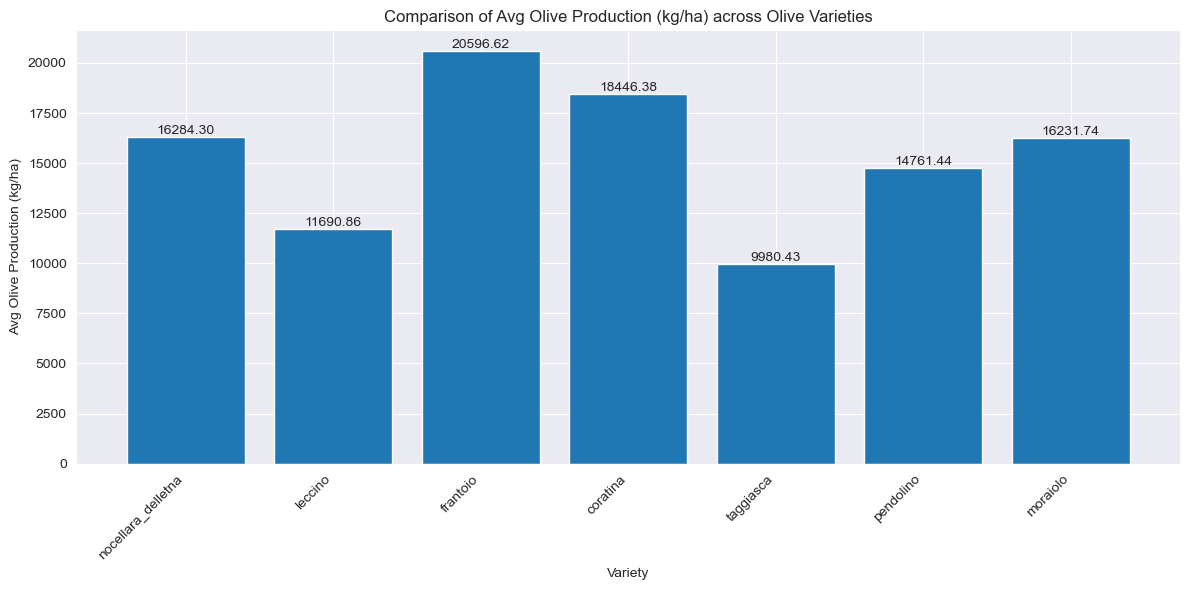

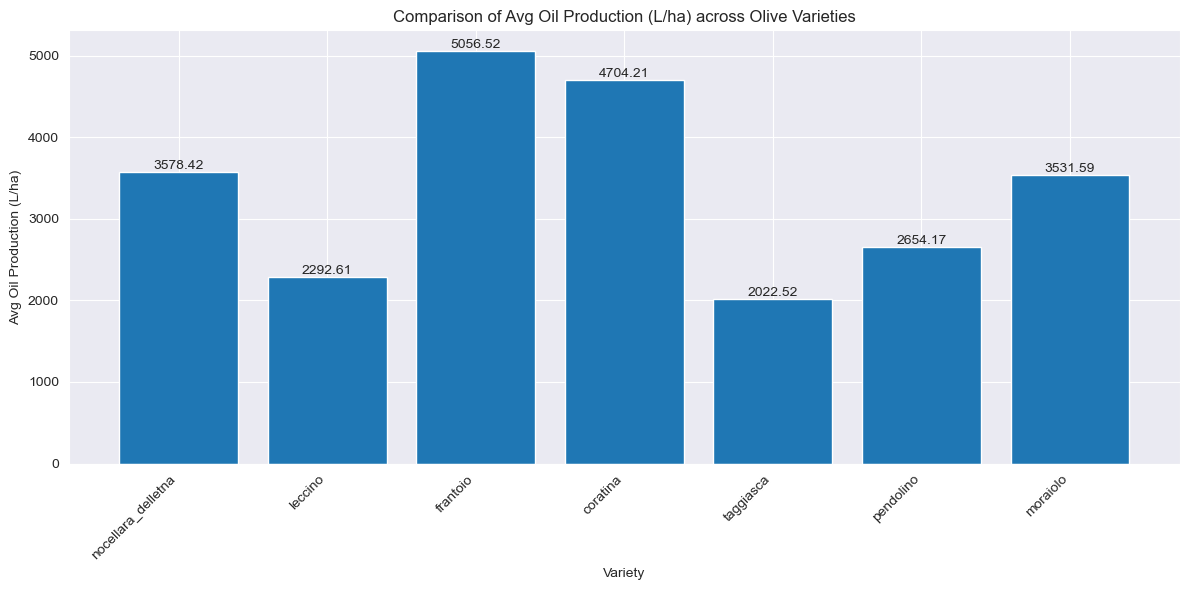

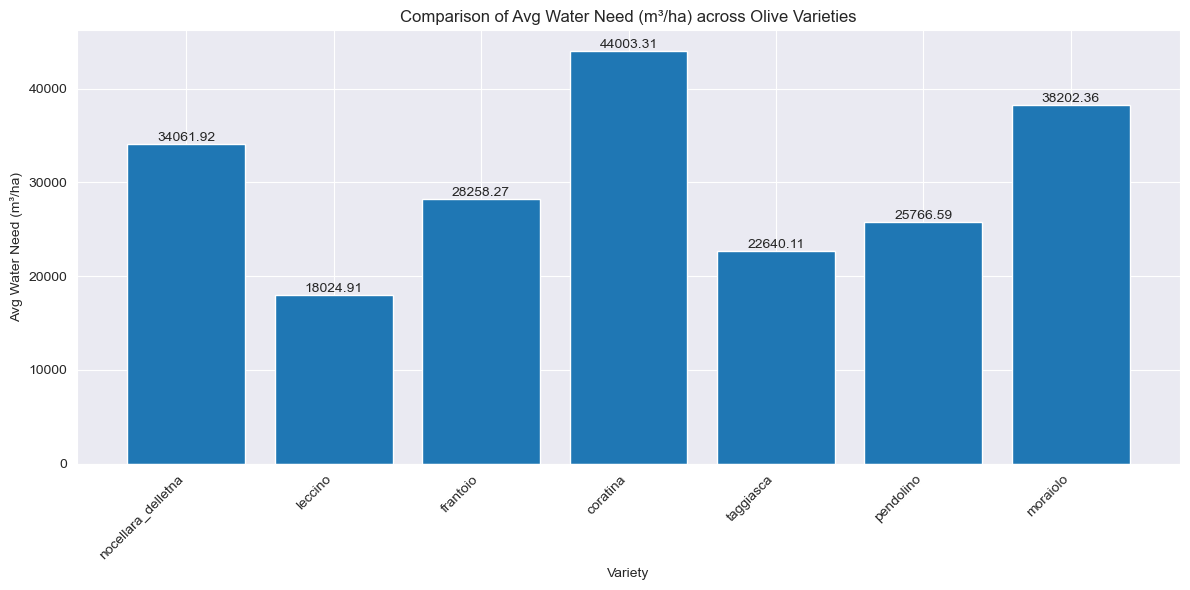

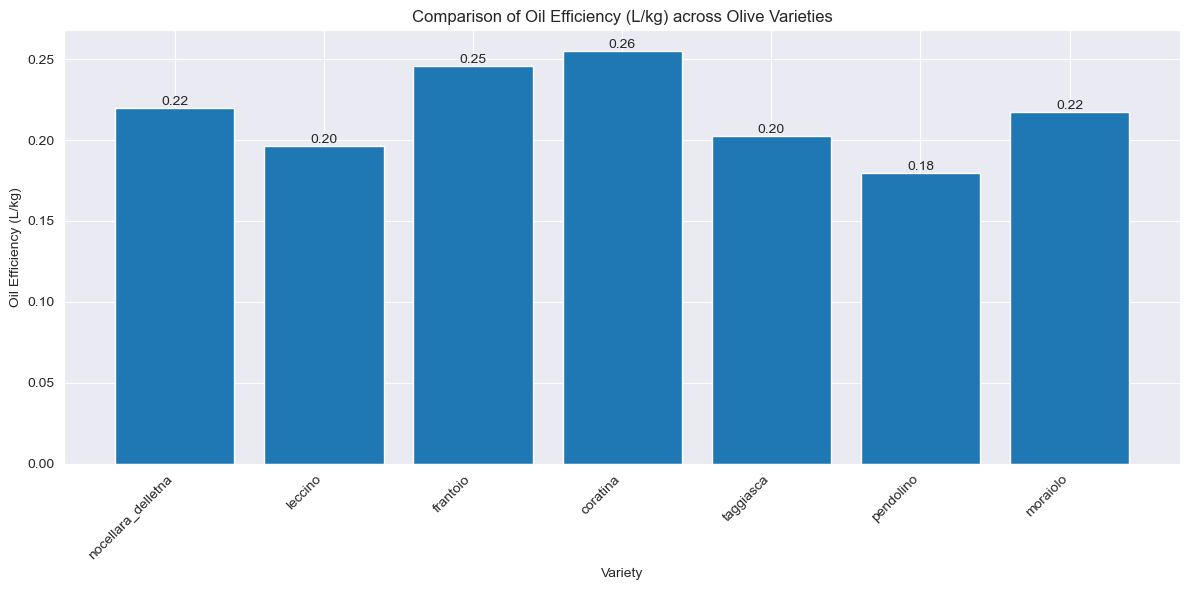

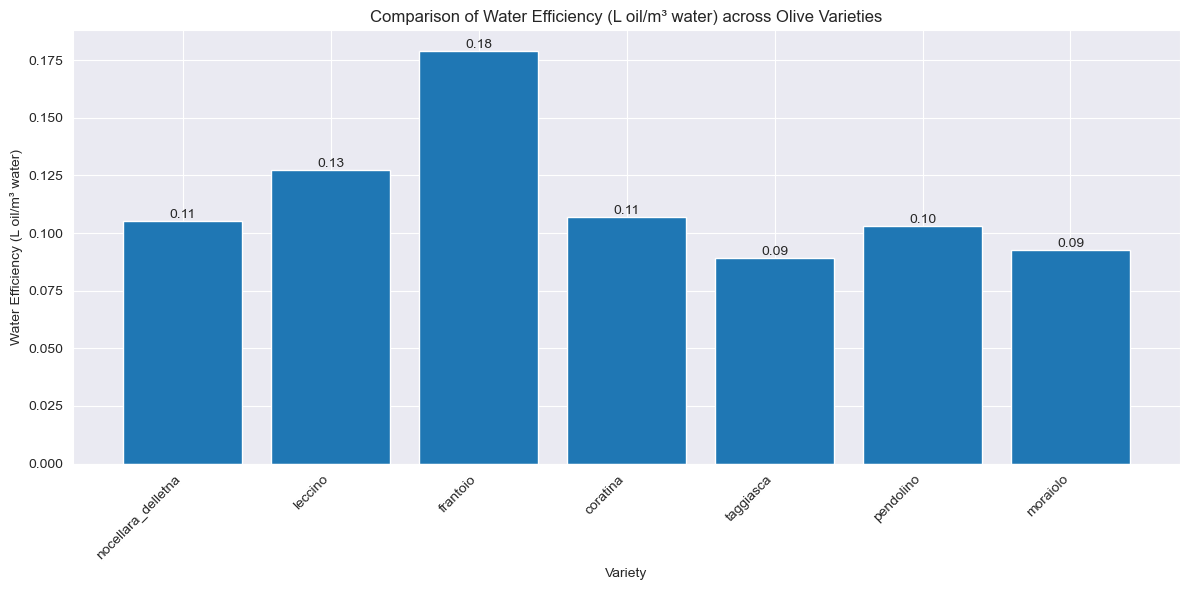

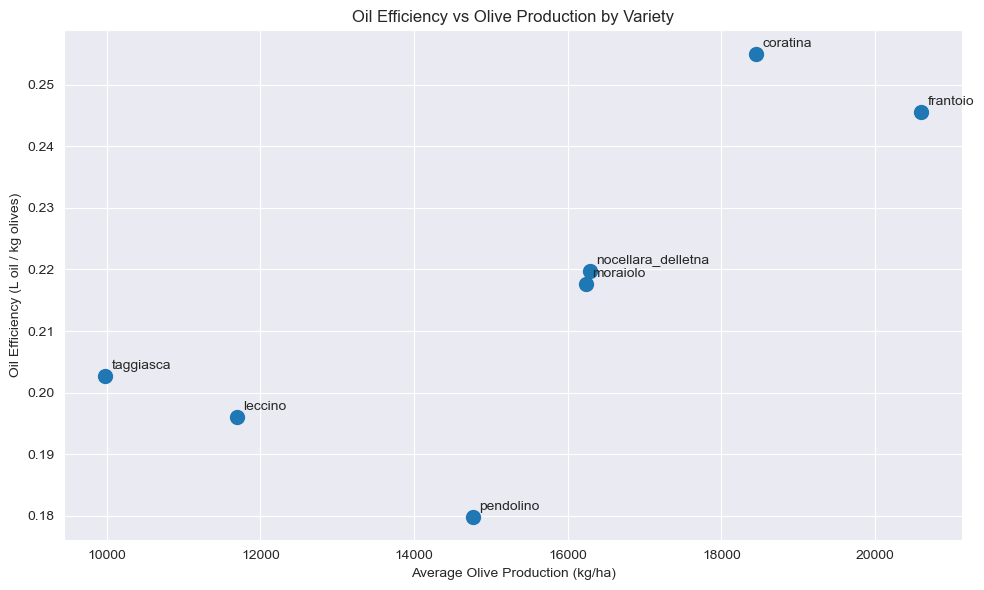

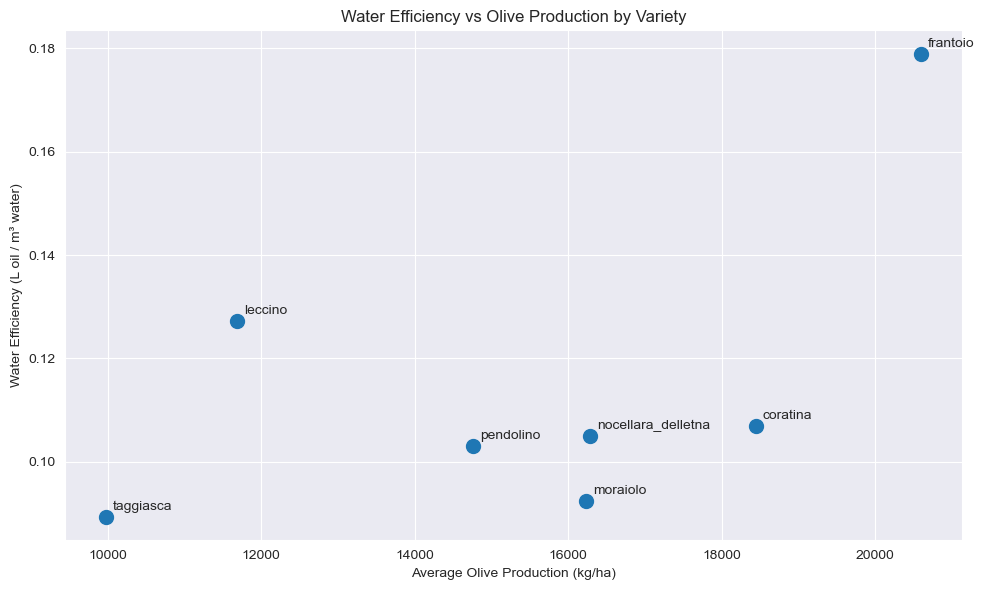

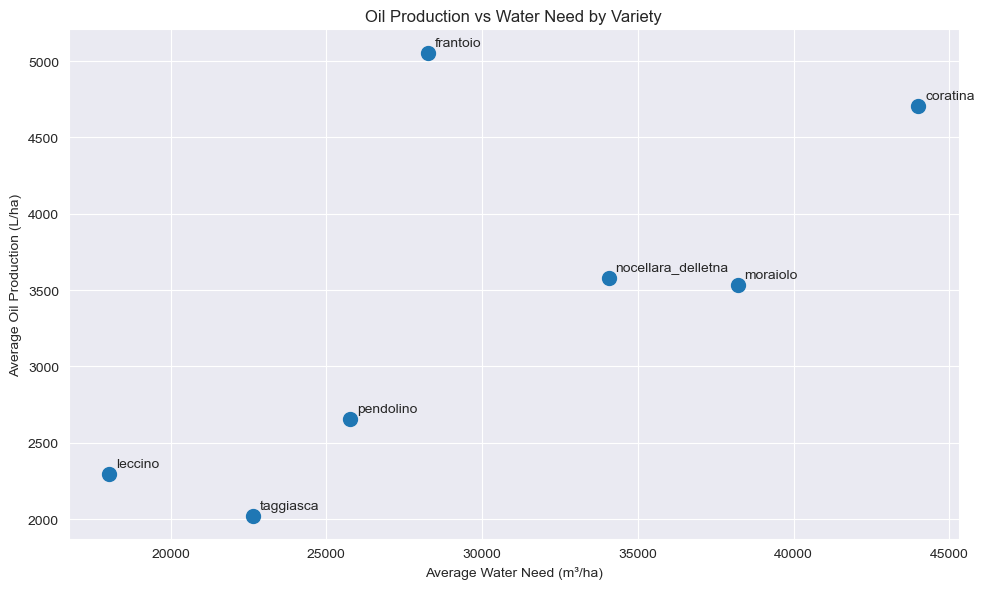

               Variety  Technique Technique String  \
0   nocellara_delletna          1        intensiva   
1   nocellara_delletna          2   superintensiva   
2   nocellara_delletna          3     tradizionale   
3              leccino          2   superintensiva   
4              leccino          1        intensiva   
5              leccino          3     tradizionale   
6             frantoio          2   superintensiva   
7             frantoio          1        intensiva   
8             frantoio          3     tradizionale   
9             coratina          3     tradizionale   
10            coratina          2   superintensiva   
11            coratina          1        intensiva   
12           taggiasca          1        intensiva   
13           taggiasca          2   superintensiva   
14           taggiasca          3     tradizionale   
15           pendolino          2   superintensiva   
16           pendolino          1        intensiva   
17           pendolino      

In [11]:
simulated_data = pd.read_parquet("./data/simulated_data.parquet")


def clean_column_names(df):
    # Funzione per pulire i nomi delle colonne
    new_columns = []
    for col in df.columns:
        # Usa regex per separare le varietà
        varieties = re.findall(r'([a-z]+)_([a-z_]+)', col)
        if varieties:
            new_columns.append(f"{varieties[0][0]}_{varieties[0][1]}")
        else:
            new_columns.append(col)
    return new_columns


def prepare_comparison_data(simulated_data, olive_varieties):
    # Pulisci i nomi delle colonne
    df = simulated_data.copy()

    df.columns = clean_column_names(df)
    df = encode_techniques(df)

    all_varieties = olive_varieties['Varietà di Olive'].unique()
    varieties = [clean_column_name(variety) for variety in all_varieties]
    comparison_data = []

    for variety in varieties:
        olive_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_olive_prod')), None)
        oil_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_avg_oil_prod')), None)
        tech_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_tech')), None)
        water_need_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_water_need')), None)

        if olive_prod_col and oil_prod_col and tech_col and water_need_col:
            variety_data = df[[olive_prod_col, oil_prod_col, tech_col, water_need_col]]
            variety_data = variety_data[variety_data[tech_col] != 0]  # Esclude le righe dove la tecnica è 0

            if not variety_data.empty:
                avg_olive_prod = pd.to_numeric(variety_data[olive_prod_col], errors='coerce').mean()
                avg_oil_prod = pd.to_numeric(variety_data[oil_prod_col], errors='coerce').mean()
                avg_water_need = pd.to_numeric(variety_data[water_need_col], errors='coerce').mean()
                efficiency = avg_oil_prod / avg_olive_prod if avg_olive_prod > 0 else 0
                water_efficiency = avg_oil_prod / avg_water_need if avg_water_need > 0 else 0

                comparison_data.append({
                    'Variety': variety,
                    'Avg Olive Production (kg/ha)': avg_olive_prod,
                    'Avg Oil Production (L/ha)': avg_oil_prod,
                    'Avg Water Need (m³/ha)': avg_water_need,
                    'Oil Efficiency (L/kg)': efficiency,
                    'Water Efficiency (L oil/m³ water)': water_efficiency
                })

    return pd.DataFrame(comparison_data)


def plot_variety_comparison(comparison_data, metric):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(comparison_data['Variety'], comparison_data[metric])
    plt.title(f'Comparison of {metric} across Olive Varieties')
    plt.xlabel('Variety')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def plot_efficiency_vs_production(comparison_data):
    plt.figure(figsize=(10, 6))

    plt.scatter(comparison_data['Avg Olive Production (kg/ha)'],
                comparison_data['Oil Efficiency (L/kg)'],
                s=100)

    for i, row in comparison_data.iterrows():
        plt.annotate(row['Variety'],
                     (row['Avg Olive Production (kg/ha)'], row['Oil Efficiency (L/kg)']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Oil Efficiency vs Olive Production by Variety')
    plt.xlabel('Average Olive Production (kg/ha)')
    plt.ylabel('Oil Efficiency (L oil / kg olives)')
    plt.tight_layout()
    plt.show()


def plot_water_efficiency_vs_production(comparison_data):
    plt.figure(figsize=(10, 6))

    plt.scatter(comparison_data['Avg Olive Production (kg/ha)'],
                comparison_data['Water Efficiency (L oil/m³ water)'],
                s=100)

    for i, row in comparison_data.iterrows():
        plt.annotate(row['Variety'],
                     (row['Avg Olive Production (kg/ha)'], row['Water Efficiency (L oil/m³ water)']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Water Efficiency vs Olive Production by Variety')
    plt.xlabel('Average Olive Production (kg/ha)')
    plt.ylabel('Water Efficiency (L oil / m³ water)')
    plt.tight_layout()
    plt.show()


def plot_water_need_vs_oil_production(comparison_data):
    plt.figure(figsize=(10, 6))

    plt.scatter(comparison_data['Avg Water Need (m³/ha)'],
                comparison_data['Avg Oil Production (L/ha)'],
                s=100)

    for i, row in comparison_data.iterrows():
        plt.annotate(row['Variety'],
                     (row['Avg Water Need (m³/ha)'], row['Avg Oil Production (L/ha)']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Oil Production vs Water Need by Variety')
    plt.xlabel('Average Water Need (m³/ha)')
    plt.ylabel('Average Oil Production (L/ha)')
    plt.tight_layout()
    plt.show()


def analyze_by_technique(simulated_data, olive_varieties):
    # Pulisci i nomi delle colonne
    df = simulated_data.copy()

    df.columns = clean_column_names(df)
    df = encode_techniques(df)
    all_varieties = olive_varieties['Varietà di Olive'].unique()
    varieties = [clean_column_name(variety) for variety in all_varieties]

    technique_data = []

    for variety in varieties:
        olive_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_olive_prod')), None)
        oil_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_avg_oil_prod')), None)
        tech_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_tech')), None)
        water_need_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_water_need')), None)

        if olive_prod_col and oil_prod_col and tech_col and water_need_col:
            variety_data = df[[olive_prod_col, oil_prod_col, tech_col, water_need_col]]
            variety_data = variety_data[variety_data[tech_col] != 0]

            if not variety_data.empty:
                for tech in variety_data[tech_col].unique():
                    tech_data = variety_data[variety_data[tech_col] == tech]

                    avg_olive_prod = pd.to_numeric(tech_data[olive_prod_col], errors='coerce').mean()
                    avg_oil_prod = pd.to_numeric(tech_data[oil_prod_col], errors='coerce').mean()
                    avg_water_need = pd.to_numeric(tech_data[water_need_col], errors='coerce').mean()

                    efficiency = avg_oil_prod / avg_olive_prod if avg_olive_prod > 0 else 0
                    water_efficiency = avg_oil_prod / avg_water_need if avg_water_need > 0 else 0

                    technique_data.append({
                        'Variety': variety,
                        'Technique': tech,
                        'Technique String': decode_single_technique(tech),
                        'Avg Olive Production (kg/ha)': avg_olive_prod,
                        'Avg Oil Production (L/ha)': avg_oil_prod,
                        'Avg Water Need (m³/ha)': avg_water_need,
                        'Oil Efficiency (L/kg)': efficiency,
                        'Water Efficiency (L oil/m³ water)': water_efficiency
                    })

    return pd.DataFrame(technique_data)


# Esecuzione dell'analisi
comparison_data = prepare_comparison_data(simulated_data, olive_varieties)

# Genera i grafici
plot_variety_comparison(comparison_data, 'Avg Olive Production (kg/ha)')
plot_variety_comparison(comparison_data, 'Avg Oil Production (L/ha)')
plot_variety_comparison(comparison_data, 'Avg Water Need (m³/ha)')
plot_variety_comparison(comparison_data, 'Oil Efficiency (L/kg)')
plot_variety_comparison(comparison_data, 'Water Efficiency (L oil/m³ water)')
plot_efficiency_vs_production(comparison_data)
plot_water_efficiency_vs_production(comparison_data)
plot_water_need_vs_oil_production(comparison_data)

# Analisi per tecnica
technique_data = analyze_by_technique(simulated_data, olive_varieties)

print(technique_data)

# Stampa un sommario statistico
print("Comparison by Variety:")
print(comparison_data.set_index('Variety'))
print("\nBest Varieties by Water Efficiency:")
print(comparison_data.sort_values('Water Efficiency (L oil/m³ water)', ascending=False).head())

## 4. Analisi della Relazione tra Meteo e Produzione

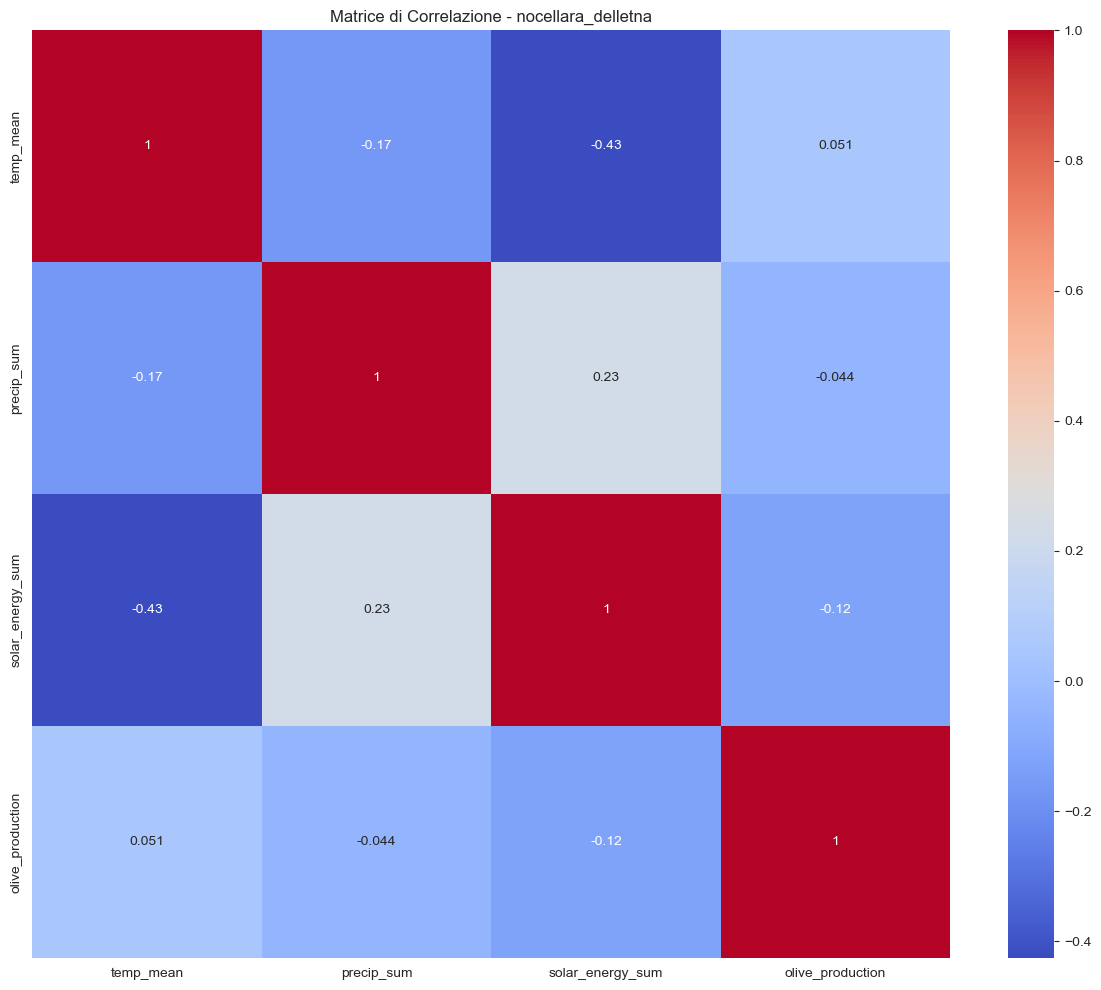

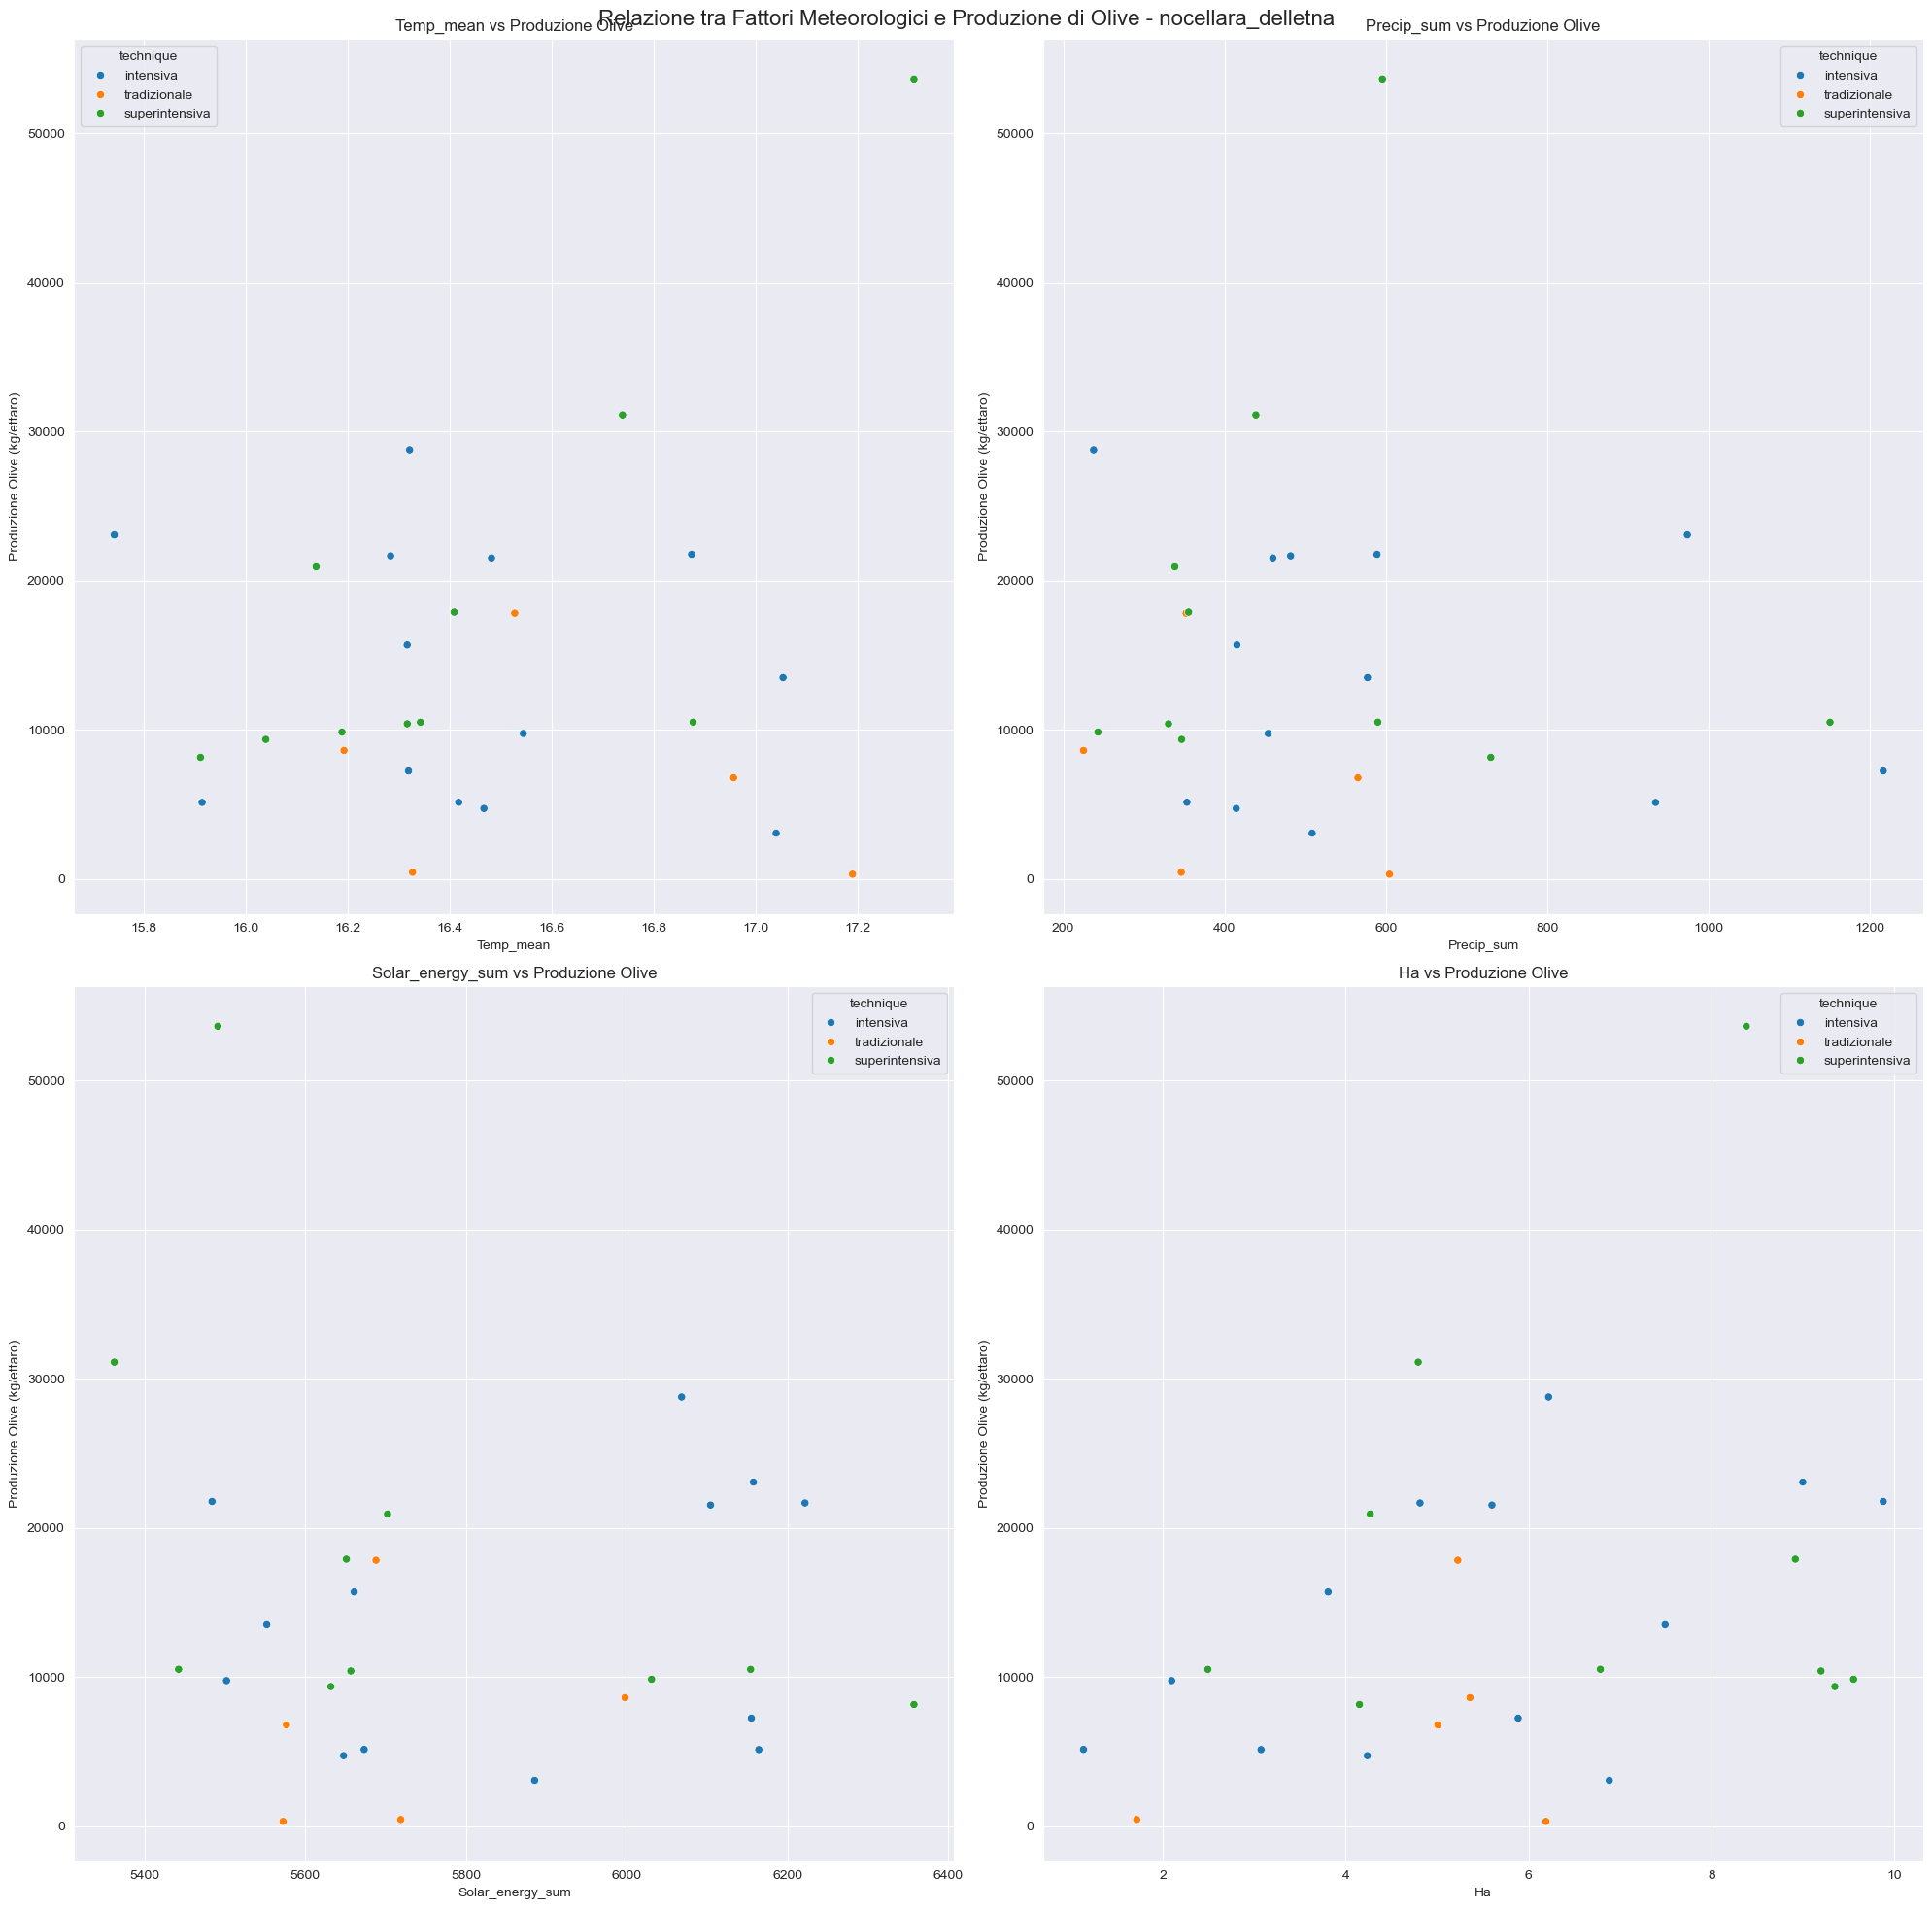

In [225]:
def get_full_data(simulated_data, olive_varieties):
    # Assumiamo che simulated_data contenga già tutti i dati necessari
    # Includiamo solo le colonne rilevanti
    relevant_columns = ['year', 'temp_mean', 'precip_sum', 'solar_energy_sum', 'ha', 'zone', 'olive_prod']

    # Aggiungiamo le colonne specifiche per varietà
    all_varieties = olive_varieties['Varietà di Olive'].unique()
    varieties = [clean_column_name(variety) for variety in all_varieties]
    for variety in varieties:
        relevant_columns.extend([f'{variety}_olive_prod', f'{variety}_tech'])

    return simulated_data[relevant_columns].copy()


def analyze_correlations(full_data, variety):
    # Filtra i dati per la varietà specifica
    variety_data = full_data[[col for col in full_data.columns if not col.startswith('_') or col.startswith(f'{variety}_')]]

    # Rinomina le colonne per chiarezza
    variety_data = variety_data.rename(columns={
        f'{variety}_olive_prod': 'olive_production',
        f'{variety}_tech': 'technique'
    })

    # Matrice di correlazione
    plt.figure(figsize=(12, 10))
    corr_matrix = variety_data[['temp_mean', 'precip_sum', 'solar_energy_sum', 'olive_production']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Matrice di Correlazione - {variety}')
    plt.tight_layout()
    plt.show()

    # Scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(f'Relazione tra Fattori Meteorologici e Produzione di Olive - {variety}', fontsize=16)

    for ax, var in zip(axes.flat, ['temp_mean', 'precip_sum', 'solar_energy_sum', 'ha']):
        sns.scatterplot(data=variety_data, x=var, y='olive_production', hue='technique', ax=ax)
        ax.set_title(f'{var.capitalize()} vs Produzione Olive')
        ax.set_xlabel(var.capitalize())
        ax.set_ylabel('Produzione Olive (kg/ettaro)')

    plt.tight_layout()
    plt.show()


# Uso delle funzioni
full_data = get_full_data(simulated_data, olive_varieties)

# Assumiamo che 'selected_variety' sia definito altrove nel codice
# Per esempio:
selected_variety = 'nocellara_delletna'

analyze_correlations(full_data, selected_variety)

## 5. Preparazione del Modello di Machine Learning

   year       temp   humidity  cloudcover  solarenergy   uvindex  \
0  2012  16.106330  72.993202   37.448833       6329.0  1.997837   
1  2013  15.699121  76.081377   41.521258       6117.0  1.931271   
2  2014  16.372383  75.403644   41.882475       6109.8  1.930243   
3  2015  16.423907  70.602369   35.372725       6174.2  1.951707   
4  2016  16.420312  69.506617   40.081317       5645.5  1.781075   

   weather_effect  olive_production  min_oil_production  max_oil_production  \
0     1164.287197       3907.500519          767.849447          938.482657   
1     -424.417623       3351.453832          658.582631          804.934326   
2      -93.418647       3467.303474          681.347844          832.758476   
3     1312.180766       3959.263268          778.021166          950.914759   
4     2366.542610       4328.289913          850.537319         1039.545612   

   avg_oil_production  min_efficiency  max_efficiency  avg_efficiency  \
0          853.166052        0.196507      

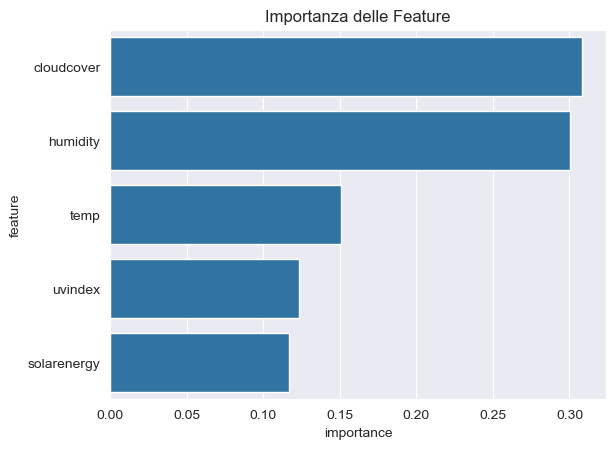

In [79]:
X = full_data[['temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex']]
y = full_data['olive_prod']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_value)

model = RandomForestRegressor(n_estimators=100, random_state=random_state_value)
model.fit(X_train, y_train)

# Valutazione del modello
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

# Importanza delle feature
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importanza delle Feature')
plt.show()

## 6. Previsioni Meteo con ARIMA

## 7. Previsione della Produzione di Olive per il Prossimo Anno

In [ ]:
next_year_production = model.predict(next_year_weather.mean().to_frame().T)[0]
print(f'Previsione produzione di olive per il prossimo anno: {next_year_production:.2f} kg/ettaro')

## 8. Conclusioni e Prossimi Passi

In questo notebook, abbiamo:
1. Caricato e analizzato i dati meteorologici
2. Simulato la produzione annuale di olive basata sui dati meteo
3. Esplorato le relazioni tra variabili meteorologiche e produzione di olive
4. Creato e valutato un modello di machine learning per prevedere la produzione
5. Utilizzato ARIMA per fare previsioni meteo
6. Previsto la produzione di olive per il prossimo anno

Prossimi passi:
- Raccogliere dati reali sulla produzione di olive per sostituire i dati simulati
- Esplorare modelli più avanzati, come le reti neurali o i modelli di ensemble
- Incorporare altri fattori che potrebbero influenzare la produzione, come le pratiche agricole o l'età degli alberi
- Sviluppare una dashboard interattiva basata su questo modello